# Initial cobb angle calculation implementation

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist

In [ ]:
# Load and preprocess the image
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Optionally apply image enhancement techniques
    enhanced = cv2.equalizeHist(gray)
    return enhanced

In [ ]:
# Detect vertebrae and endplates (using edge detection as a simple example)
def detect_edges(image):
    edges = cv2.Canny(image, 50, 150)
    return edges

In [ ]:
# Find lines corresponding to vertebral endplates
def find_endplate_lines(edges):
    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=10)
    return lines

In [ ]:
 #Selected the uppermost and lowermost lines (as endplates)
def select_endplates(lines):
    if lines is None:
        return None, None

    lines = lines[:, 0, :]
    sorted_lines = sorted(lines, key=lambda x: x[1])

    upper_endplate = sorted_lines[0]
    lower_endplate = sorted_lines[-1]

    return upper_endplate, lower_endplate

In [ ]:
# Step 5: Calculate the Cobb angle
def calculate_cobb_angle(upper_line, lower_line):
    def line_slope(line):
        x1, y1, x2, y2 = line
        return (y2 - y1) / (x2 - x1)

    slope1 = line_slope(upper_line)
    slope2 = line_slope(lower_line)

    angle_radians = np.arctan(abs((slope2 - slope1) / (1 + slope2 * slope1)))
    angle_degrees = np.degrees(angle_radians)
    return angle_degrees

Cobb Angle: 84.47 degrees


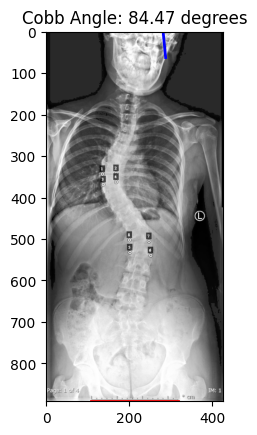

In [ ]:
# Example pipeline
image_path = "/content/drive/MyDrive/SCOLIOSIS MODEL/test/N5, Rt TAIS, F, 13 yrs.jpg"
image = load_and_preprocess_image(image_path)
edges = detect_edges(image)
lines = find_endplate_lines(edges)
upper_line, lower_line = select_endplates(lines)

if upper_line is not None and lower_line is not None:
    cobb_angle = calculate_cobb_angle(upper_line, lower_line)
    print(f"Cobb Angle: {cobb_angle:.2f} degrees")
else:
    print("Could not detect sufficient vertebral endplates.")

# Visualize the result
plt.imshow(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))
if upper_line is not None:
    plt.plot([upper_line[0], upper_line[2]], [upper_line[1], upper_line[3]], color='blue', linewidth=2)
if lower_line is not None:
    plt.plot([lower_line[0], lower_line[2]], [lower_line[1], lower_line[3]], color='red', linewidth=2)
plt.title(f'Cobb Angle: {cobb_angle:.2f} degrees')
plt.show()

<ipython-input-13-1249d362e4b4>:38: RuntimeWarning: divide by zero encountered in scalar divide
  filtered_lines = [line for line in lines if 0.2 < abs((line[3] - line[1]) / (line[2] - line[0])) < 5]


Could not detect sufficient vertebral endplates.


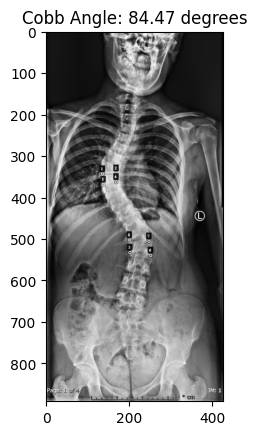

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load and preprocess the image
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Enhance the image using adaptive histogram equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    return enhanced

# Step 2: Detect edges in the image
def detect_edges(image):
    edges = cv2.Canny(image, 50, 150)
    return edges

# Step 3: Focus on Region of Interest (ROI) - spinal column
def extract_spinal_region(image):
    height, width = image.shape
    # Focus on the center region (where the spine is expected)
    roi = image[:, width // 3: 2 * width // 3]
    return roi

# Step 4: Find lines corresponding to vertebral endplates
def find_endplate_lines(edges):
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)
    return lines

# Step 5: Filter and select appropriate lines
def select_endplates(lines, image_height):
    if lines is None:
        return None, None

    lines = lines[:, 0, :]  # Extract coordinates
    # Filter lines based on their slope and position (exclude near-horizontal and vertical lines)
    filtered_lines = [line for line in lines if 0.2 < abs((line[3] - line[1]) / (line[2] - line[0])) < 5]

    if not filtered_lines:
        return None, None

    # Sort by y-coordinate (to identify uppermost and lowermost lines)
    sorted_lines = sorted(filtered_lines, key=lambda x: x[1])

    # Select the uppermost and lowermost lines within the spinal region
    upper_endplate = sorted_lines[0] if sorted_lines[0][1] < image_height / 2 else None
    lower_endplate = sorted_lines[-1] if sorted_lines[-1][3] > image_height / 2 else None

    return upper_endplate, lower_endplate

# Step 6: Calculate the Cobb angle
def calculate_cobb_angle(upper_line, lower_line):
    def line_slope(line):
        x1, y1, x2, y2 = line
        return (y2 - y1) / (x2 - x1)

    slope1 = line_slope(upper_line)
    slope2 = line_slope(lower_line)

    angle_radians = np.arctan(abs((slope2 - slope1) / (1 + slope2 * slope1)))
    angle_degrees = np.degrees(angle_radians)
    return angle_degrees

# Example pipeline
image_path = "/content/drive/MyDrive/SCOLIOSIS MODEL/test/N5, Rt TAIS, F, 13 yrs.jpg"
image = load_and_preprocess_image(image_path)

# Extract the spinal region and focus on it
spinal_region = extract_spinal_region(image)

# Edge detection on the spinal region
edges = detect_edges(spinal_region)

# Detect endplate lines in the spinal region
lines = find_endplate_lines(edges)
height, _ = spinal_region.shape
upper_line, lower_line = select_endplates(lines, height)

if upper_line is not None and lower_line is not None:
    cobb_angle = calculate_cobb_angle(upper_line, lower_line)
    print(f"Cobb Angle: {cobb_angle:.2f} degrees")
else:
    print("Could not detect sufficient vertebral endplates.")

# Visualize the result
plt.imshow(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))
# Adjust lines to the original image's coordinate system
if upper_line is not None:
    plt.plot([upper_line[0] + image.shape[1] // 3, upper_line[2] + image.shape[1] // 3],
             [upper_line[1], upper_line[3]], color='blue', linewidth=2)
if lower_line is not None:
    plt.plot([lower_line[0] + image.shape[1] // 3, lower_line[2] + image.shape[1] // 3],
             [lower_line[1], lower_line[3]], color='red', linewidth=2)
plt.title(f'Cobb Angle: {cobb_angle:.2f} degrees')
plt.show()


# updated cobb angle calculation

In [2]:


# VIA Manual Annotation

!wget https://www.robots.ox.ac.uk/~vgg/software/via/via-2.0.10.html -O via.html

from google.colab import files
files.download('via.html') #run only once this part because it gives the link to the platform to do manual annotaion so dont need to run each time.

# Cobb Angle Calculation

import pandas as pd
import numpy as np
import json


# Load the annotation file (CSV example)
annotation_path = '/content/drive/MyDrive/SCOLIOSIS MODEL/test/3_csv.csv'
annotations = pd.read_csv(annotation_path)

# Function to extract 'cx' and 'cy' from the 'region_shape_attributes' column
def extract_coordinates(row):
    data = json.loads(row)  # Convert the string to a dictionary
    return pd.Series([data.get('cx', None), data.get('cy', None)])  # Extract 'cx' and 'cy'

# Apply the function to the 'region_shape_attributes' column to create 'cx' and 'cy' columns
annotations[['cx', 'cy']] = annotations['region_shape_attributes'].apply(extract_coordinates)
# Display the updated dataframe
print(annotations)


# Extract upper and lower endplate points
# Assuming the first 4 points are for Cobb angle calculation
upper_point_1 = (annotations.iloc[0]['cx'], annotations.iloc[0]['cy'])  # First point of upper vertebra
upper_point_2 = (annotations.iloc[1]['cx'], annotations.iloc[1]['cy'])  # Second point of upper vertebra
lower_point_1 = (annotations.iloc[2]['cx'], annotations.iloc[2]['cy'])  # First point of lower vertebra
lower_point_2 = (annotations.iloc[3]['cx'], annotations.iloc[3]['cy'])  # Second point of lower vertebra

# Cobb Angle Calculation function
def calculate_cobb_angle(upper_line, lower_line):
    def line_slope(line):
        x1, y1, x2, y2 = line
        return (y2 - y1) / (x2 - x1) if x2 != x1 else float('inf')

    # Get the slopes of the two lines
    slope1 = line_slope(upper_line)
    slope2 = line_slope(lower_line)

    # Calculate the angle in radians between the two lines
    if slope1 == float('inf') or slope2 == float('inf'):
        angle_radians = np.pi / 2  # 90 degrees if one line is vertical
    else:
        angle_radians = np.arctan(abs((slope2 - slope1) / (1 + slope2 * slope1)))

    # Convert the angle to degrees
    angle_degrees = np.degrees(angle_radians)
    return angle_degrees

# Define the lines using the points
upper_line = [upper_point_1[0], upper_point_1[1], upper_point_2[0], upper_point_2[1]]
lower_line = [lower_point_1[0], lower_point_1[1], lower_point_2[0], lower_point_2[1]]

# Calculate the Cobb angle
cobb_angle = calculate_cobb_angle(upper_line, lower_line)
print(f'Cobb Angle: {cobb_angle:.2f} degrees')


--2024-09-12 09:10:22--  https://www.robots.ox.ac.uk/~vgg/software/via/via-2.0.10.html
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘via.html’

via.html                [   <=>              ] 411.65K   471KB/s    in 0.9s    

2024-09-12 09:10:24 (471 KB/s) - ‘via.html’ saved [421527]



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                    filename  file_size file_attributes  region_count  \
N10  Rt TAIS  M   16 yrs.jpg     275503              {}             8   
              M   16 yrs.jpg     275503              {}             8   
              M   16 yrs.jpg     275503              {}             8   
              M   16 yrs.jpg     275503              {}             8   
              M   16 yrs.jpg     275503              {}             8   
              M   16 yrs.jpg     275503              {}             8   
              M   16 yrs.jpg     275503              {}             8   
              M   16 yrs.jpg     275503              {}             8   

                 region_id              region_shape_attributes  \
N10  Rt TAIS  M          0   {"name":"point","cx":318,"cy":981}   
              M          1   {"name":"point","cx":465,"cy":976}   
              M          2  {"name":"point","cx":321,"cy":1068}   
              M          3  {"name":"point","cx":473,"cy":1073}   
       